In [1]:
%matplotlib inline

In [98]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import xlrd
import sqlite3
import os
import models
import patsy
import sklearn.linear_model as linear
import random
from IPython.display import HTML
import math

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

## 1.1 - ETL


In [3]:
import pandas as pd
import io
import requests

"""
This function takes the initial url, and returns the bytes for the URL. After that, it will generate a list, each entery
being a new line. These lines will then be cleaned up, and returned as a final list, which will be used to create a 
Data Frame. Some last minute cleaning will occur at this stage as well.
"""
def GenerateList(url):
    s=requests.get(auto_mpg_data).content #gets bytes from url
    string = s.decode("utf-8") #turns bytes into string
    split_string = string.split("\n") #splits string by new line character

    temp_string = []
    for item in split_string:
        temp_string.append(item.replace("\t", ' ')) #cleans out all \t enteries

    temp_string = temp_string[:-1] #trims the last "empty" row

    temp = []
    for item in temp_string:
        temp_item = item.replace("?", "0") #replaces a bad entry with an int, so that the column can be modified
        temp.append(temp_item)
    temp_string = temp

    final_list = []
    for line in temp_string: #creates a final list based on the character placement within the file
        temp = []
        temp.append(float(line[:4]))
        temp.append(int(line[6:10]))
        temp.append(float(line[11:16]))
        temp.append(float(line[19:30]))
        temp.append(float(line[31:40]))
        temp.append(float(line[41:50]))
        temp.append(int(line[51:55]))
        temp.append(int(line[55:57]))
        temp.append(line[58:-1])
        final_list.append(temp)
    return final_list #returns final, cleaned up list


#starting URL
url="https://raw.githubusercontent.com/cs109/2014_data/master/countries.csv"

#creates polished list
final_list = GenerateList(url)

#turns polished list into a dataframe with column headers
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'modelyear', 'origin', 'car name']
data = pd.DataFrame(final_list, columns=columns)

In [4]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## 1.2 - EDA


Our mail goal here is going to be getting a feel for the data. We'll also look for data quality issues. We'll begin by looking at each variable by itself, before looking at how the data is paired with our target variable, which is mpg.

### Single Variable:

***Single Variable - MPG***

Name: Miles Per Gallon (MPG)

Data Type: Continuous

Priority: Target Variable

Description: MPG is the target variable, and it measures the efficiency if the vehicle to travel distances by gasoline usage.

Expectation: I expect this variable to be mostly evenly distributed, with a gradual reduction the higher we go. We shouldn't have any negative number, nor should we have anything 50+. There may be some enteries that are low though, in the 5-10 range, as some semi trucks or older vehicles are known for being extremely inefficient.

We'll start by getting a feel for the data by running .describe against the column. This will tell us the mean, standard deviation, and the limits.

In [5]:
data["mpg"].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The good news is we don't seem to have any values that are outside of our expected ranges. The mean is at 23, which is close to the middle of the 0 to the max. The standard deviation is about 1/3 of the mean, which is pretty high, so I don't expect the data to be too centered near the mean.

We'll next take a look at the graph for this data to make sure it looks good.

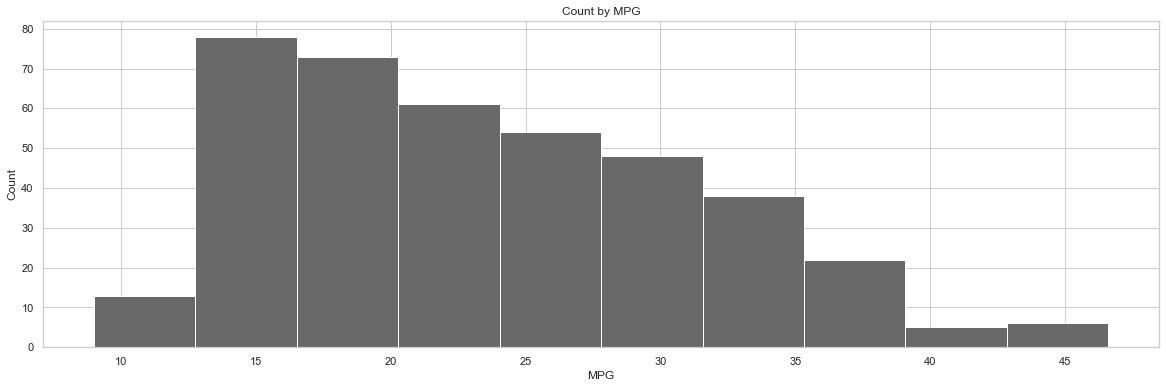

In [6]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["mpg"],  color="dimgray")
axes.set_title( "Count by MPG")
axes.set_xlabel("MPG")
axes.set_ylabel("Count")

plt.show()
plt.close()

Interestingly we see that the data is very step like, with a gradual decline, before leading into a tail ending at 47 mpg. There are around 11 enteries that come lower than 15, but these enteries do not appear to be data problems, instead they are just really fuel inefficient autos.

***Single Variable - cylinders***

Name: cylinders

Data Type: discrete

Description: The number of cylinders within the engine of the auto.

Expectation: There are several different engine options, generally from my understanding there is 4, 6, 8 cylinders, with some outlier types such as a Hemi and the like. I would imagine that there is a pretty uniform distribution of these values, anything that is negative, zero, or unnaturally high would likely be caused by an outlier.

We'll start by examining the general descriptive statistics of the attribute.

In [7]:
data["cylinders"].describe()

count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

I had to look it up, but there is such a thing as a 3 cylinder car. It appears that these were generally constructed by Audi. The rest of the values seem fine, with no negatives or abnormally large data points.

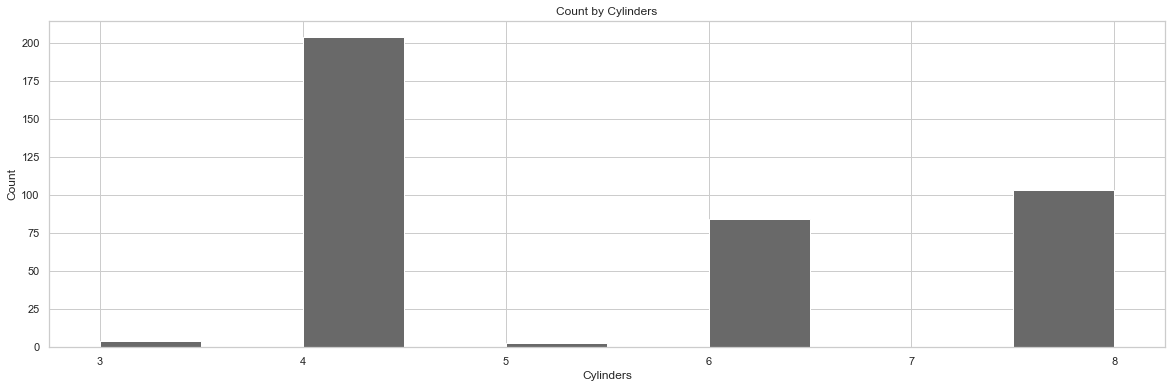

In [8]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["cylinders"],  color="dimgray")
axes.set_title( "Count by Cylinders")
axes.set_xlabel("Cylinders")
axes.set_ylabel("Count")

plt.show()
plt.close()

We see that 4, 6, and 8 are by far the largest representations shown, with some vehciles in the 3 and 5 categories. It'll be interesting to see how these odd cylinders affect our model.

***Single Variable - displacement***

Name: displacement

Data Type: continuous

Description: The measure of the cylinder volume swept by all of the pistons of a piston engine, excluding the combustion chambers.

Expectation: Displacement should be a pretty spread out dataset, similar to MPG, with a lot of the data ponits focused around a point, with a gradual decline. We'll mostly be looking out for outliers with this data set, to make sure that we don't have any errors that would affect our model efficiency. No values should be 0 nor should we have data that is too far out of the norm.

We'll start by looking at the descriptive statistics. I expect to see a good distribution, without outliers, but a nice tail.

In [9]:
data["displacement"].describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

The max immediately stands out to me, as being abnormally large. This could a true data point, which we'll verify with the graph. Everything else looks good, we have nice segments with the 25, 50, and 75 percentiles.

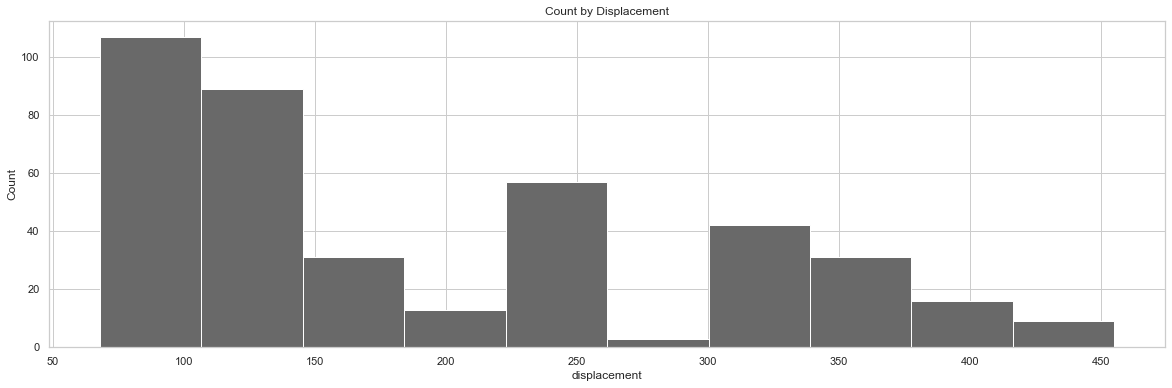

In [10]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["displacement"],  color="dimgray")
axes.set_title( "Count by Displacement")
axes.set_xlabel("displacement")
axes.set_ylabel("Count")

plt.show()
plt.close()

I'm a bit surprised by how gradual the tail is. We see that in fact the max value at 455 doesn't appear to be an outlier, as we have nearly 10 values in that range. Our initial assumption of the gradual reduction in the distance looks to prove accurate. There are some peaks, which could be attributed to different cylinder counts, which helps to explain the grouping at 100, 250, and 325.

***Single Variable - horsepower***

Name: horsepower

Data Type: continuous

Description: A measurement of the power of an engine, the higher the horsepower, the more power the automobile has.

Expectation: Horsepower should follow a lot of the same concepts explained previously, with a nice tail. Additionally, I'll be on the lookout for data quality issues, such as negative, zero, or abnormally large data points.

We'll start by examining the descriptive statistics.

In [11]:
data["horsepower"].describe()

count    398.000000
mean     102.894472
std       40.269544
min        0.000000
25%       75.000000
50%       92.000000
75%      125.000000
max      230.000000
Name: horsepower, dtype: float64

The min amount will need to be removed, as no cars should have 0 horsepower. Additionally, I'll be interested to see how much of an outlier the max value is.

Before we generate the bar chart for this attribute, I'll create a limit, so that all data with horsepower == 0 is dropped. From there we'll generate the barchart, which should look similar to the previous charts.

In [12]:
data = data.loc[data["horsepower"] > 0]

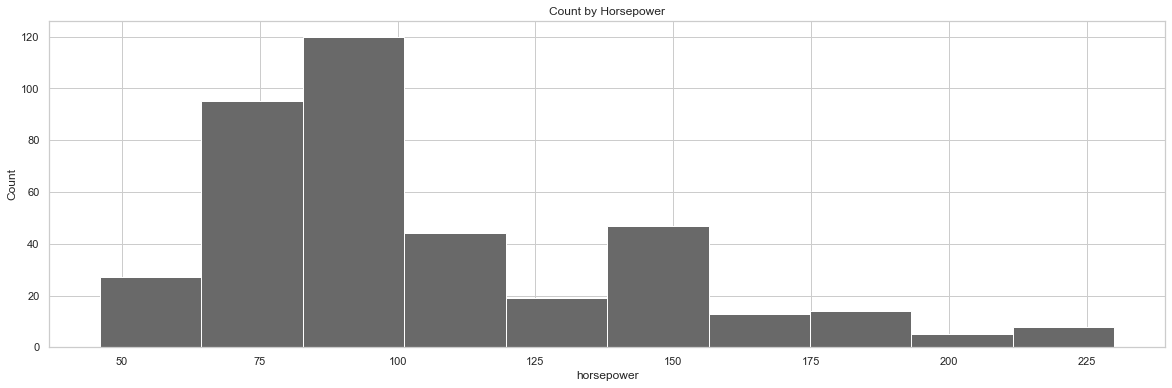

In [13]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["horsepower"],  color="dimgray")
axes.set_title( "Count by Horsepower")
axes.set_xlabel("horsepower")
axes.set_ylabel("Count")

plt.show()
plt.close()

The data is a bit more normally distributed than what I was originally expected. This could be related to how cylinder count and weight play together. There is however, a large right tail on the data, which may be useful when performing a two variable analysis.

***Single Variable - weight***

Name: weight

Data Type: continuous

Description: the amount of pounds the car weighs.

Expectation: We expect larger cars, and cars with larger cylinder counts weigh more on avarage. This is an important variable, as the weight of the car will play a direct roll in the amount of energy required to move it. I will mostly be on the lookout for abnormally small or large data points.

We'll start by looking at the descriptive statistics.

In [14]:
data["weight"].describe()

count     392.000000
mean     2977.584184
std       849.402560
min      1613.000000
25%      2225.250000
50%      2803.500000
75%      3614.750000
max      5140.000000
Name: weight, dtype: float64

There doesn't appear to be any outliers with this data set. We have a mean around 2977, with a standard deviation at about 27.5% of the mean. Additionally, the percentiles look to be within what we would expect for this type of data.

We'll next take a look at how the graph looks, to make sure that we don't have any weird bunching up. Additionally we'll be able to get a general feel for the data this way as well.

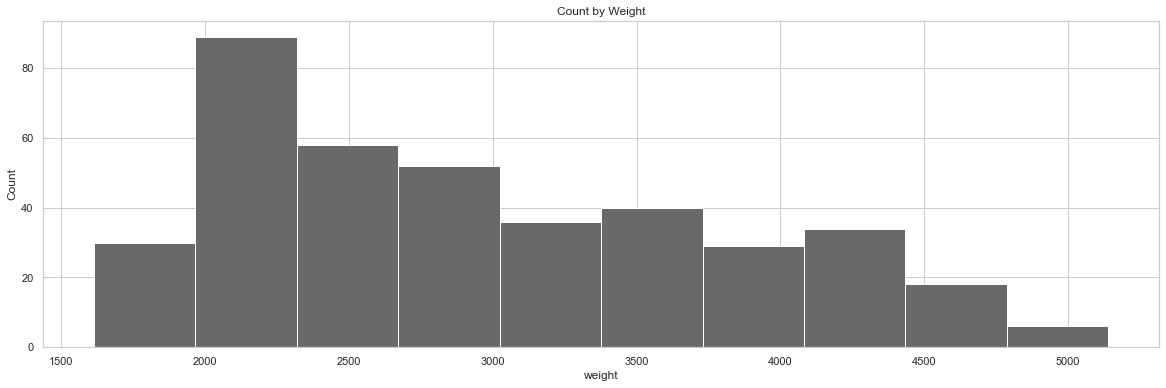

In [15]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["weight"],  color="dimgray")
axes.set_title( "Count by Weight")
axes.set_xlabel("weight")
axes.set_ylabel("Count")

plt.show()
plt.close()

The weight appears to have a similar distribution to horsepower. This would make sense, as in order to mae a heavy auto move as fast as a light auto, more horsepower would be required.

***Single Variable - acceleration***

Name: acceleration

Data Type: continuous

Description: The amount of seconds it takes a car to travel 0.25 miles, from a standstill.

Expectation: My guess is that this data would follow a similar distribution to weight and horsepower, albiet with a smaller band. In addition, we shouldn't see anything too out there, like a 180 second half mile. Additionally we'll be on the lookout for really small numbers, such as 0.5 or something similar.

We'll start by examining the descriptive statistics.

In [16]:
data["acceleration"].describe()

count    392.000000
mean      15.541327
std        2.758864
min        8.000000
25%       13.775000
50%       15.500000
75%       17.025000
max       24.800000
Name: acceleration, dtype: float64

Most of these numbers are well within what we would expect, an 8 second 0.25 mile isn't too outrageous. The percentiles look good, and our mean is close to the middle of the min and max. This makes me think that this data will be closer to normally distributed than some of the others attributes.

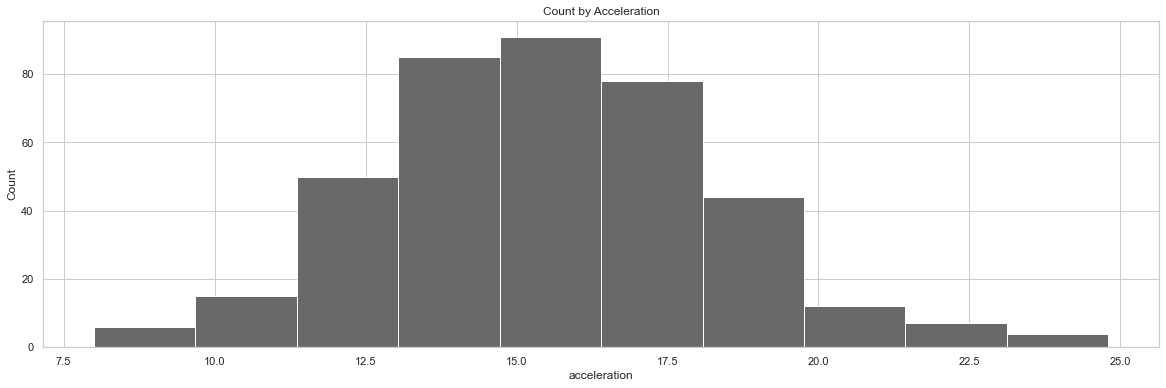

In [17]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["acceleration"],  color="dimgray")
axes.set_title( "Count by Acceleration")
axes.set_xlabel("acceleration")
axes.set_ylabel("Count")

plt.show()
plt.close()

The descriptive statistics were right, this data is really close to normally distributed. This is really interesting, it could mean that this is a target value for the automobile industry to hit, by balancing the weight and horsepower of the auto. My guess is that this is highly coorelated to those two values, and would also be a good indicator for mpg.

***Single Variable - model year***

Name: model year

Data Type: continuous

Description: Formatted by 19YY, and is based on the model year of the automobile, not necessarily it's production year. 

Expectation: This will help to give us an understanding of what model's of auto we're dealing with. This is an interesting value as there was some regulatory limitations placed, so we may not see that higher years means a more fuel efficient car. We shouldn't experience any outliers however, such as a 1901 car, as they weren't readily available.

We'll start by looking at the descriptive statistics.

In [18]:
data["modelyear"].describe()

count    392.000000
mean      75.979592
std        3.683737
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: modelyear, dtype: float64

It appears that we are just looking at cars manufactured from 1970 - 1982, which would make sense given the data was used in the 1983 American Statistical Association Exposition. We don't appear to be having any major data integrity issues, and our data looks to be pretty uniformally distributed.

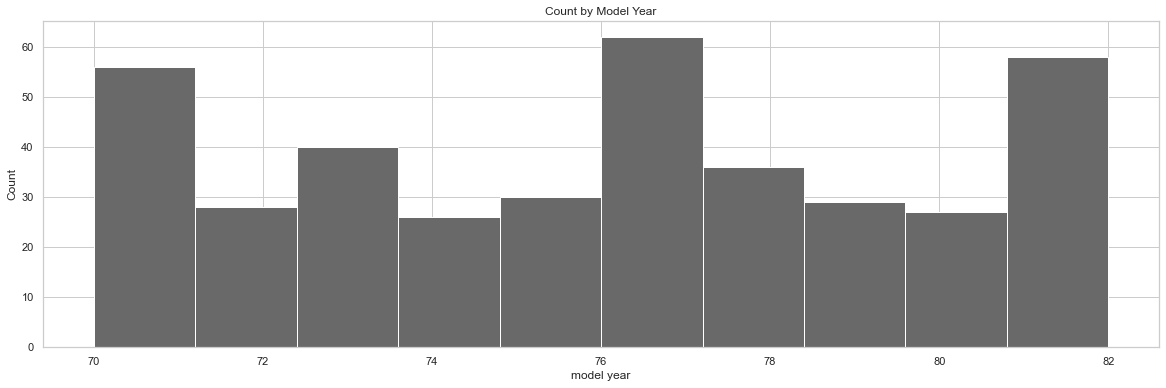

In [19]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["modelyear"],  color="dimgray")
axes.set_title( "Count by Model Year")
axes.set_xlabel("model year")
axes.set_ylabel("Count")

plt.show()
plt.close()

We see that the data is really uniformally distributed, with a few peaks. There isn't much to say about this data at this time, as we'll take a closer look when we do a two variable analysis.

***Single Variable - origin***

Name: origin

Data Type: continuous

Description: This is a bit of a sleeper, I'm not sure what this variable is.

Expectation: We'll take a close look to see how this variable is distributed, comparing it to the other's we've looked at so far. Additionally, we'll be looking for any outlier data points.

We'll start by examining the descriptive statistics.

In [20]:
data["origin"].describe()

count    392.000000
mean       1.576531
std        0.805518
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: origin, dtype: float64

It looks like there are three different options available: 1, 2, 3. It also apppears that 1 is the most represented, making up at least 50% of the enteries. 

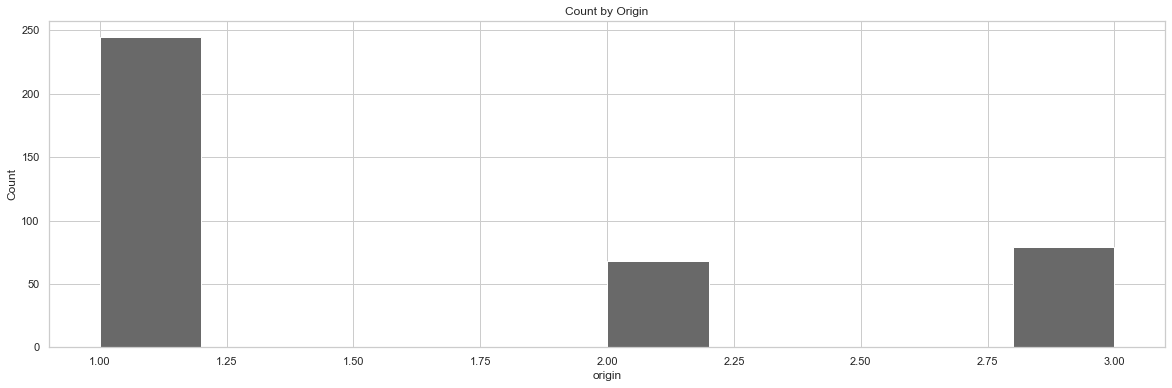

In [21]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["origin"],  color="dimgray")
axes.set_title( "Count by Origin")
axes.set_xlabel("origin")
axes.set_ylabel("Count")

plt.show()
plt.close()

It's unclear how this variable might play a role in mpg, but we'll take a closer look during the two variable analysis.

***Single Variable - car name***

Name: car name

Data Type: string

Description: The name of the car being examined.

Expectation: I'm interested to see how this data is distributed. For instance, a car from 1973 could have a model in 1974, will the name remain the same?

In order to get a feel for this data, I'll be doing a count by unique value, which should let us know a bit more about the attribute.

In [22]:
data['car name'].value_counts()

ford pinto                        5
amc matador                       5
toyota corolla                    5
ford maverick                     4
amc hornet                        4
                                 ..
pontiac catalina brougham         1
plymouth satellite custom (sw)    1
datsun 310                        1
oldsmobile vista cruiser          1
ford ltd landau                   1
Name: car name, Length: 301, dtype: int64

There are 301 unique values, with around 390 total rows, which means that there is a bit of duplication occuring. There is too many unqiue values to really be able to visualizing it via a graph, so I'll exclude that for this attribute.

**Single Variable - Take Aways**

For the single variable data, we have removed any outliers we encountered, mostly focused around horsepower. Additionally, we have a few varables that have proven interesting, which may end up being interesting variables when paired with our target variable mpg.

### Two Variable Analysis

**two variable - mpg - cylinders**

data types: continuous - discrete

Expectations: There will be a negative coorelation between the two variables, as more cylinders are added, there will need to be more gas pumped into the engine to move each of the cylinders. This paired with the fact that higher cylinder cars, such as trucks tend to be a trade off of power and efficiency.


The first technique we'll be using to see how this data is paired, is to look at the r and rho values. This will allow us to get a feel for how the cylinder and mpg variables trend, for instance are they positively or negatively coorelated, and if so by how much.

In [23]:
print( "r =", stats.pearsonr(data["cylinders"], data["mpg"])[0])
print( "rho =", stats.spearmanr(data["cylinders"], data["mpg"])[0])

r = -0.7776175081260256
rho = -0.8231746391245731


We see that our expectation of the relation between these two variables was correct, they are negatively correlated. This should lead to a distribution in a graph going from the top left to the bottom right. Cylinders is unique however, as it is really bucketed into a few discrete values. Therefore, in order to show this, I'll be making the data into a box plot, so that we can see how it trends, and get a feel for the distribution of mpg within each of the cylinders.

In [24]:
grouped = data.groupby("cylinders")
grouped_y = grouped["mpg"].describe()
print(grouped_y)

           count       mean       std   min    25%    50%    75%   max
cylinders                                                             
3            4.0  20.550000  2.564501  18.0  18.75  20.25  22.05  23.7
4          199.0  29.283920  5.670546  18.0  25.00  28.40  32.95  46.6
5            3.0  27.366667  8.228204  20.3  22.85  25.40  30.90  36.4
6           83.0  19.973494  3.828809  15.0  18.00  19.00  21.00  38.0
8          103.0  14.963107  2.836284   9.0  13.00  14.00  16.00  26.6


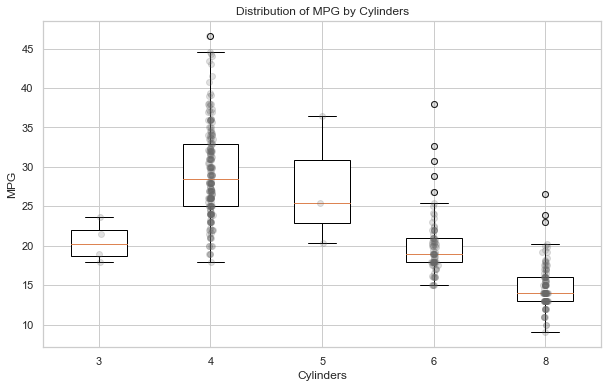

In [25]:
grouped = data.groupby("cylinders")

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(data["cylinders"].values)
labels.sort()
grouped_data = [grouped[ "mpg"].get_group( k) for k in labels]
patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1,)

for i, k in enumerate(labels):
    subdata = grouped[ "mpg"].get_group( k)
    x = np.random.normal(i + 1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.2, color="DimGray",)
    
for b in patch['boxes']:
    b.set_facecolor('w')
    
axes.set_xlabel("Cylinders")
axes.set_ylabel("MPG")
axes.set_title("Distribution of MPG by Cylinders")

plt.show()
plt.close()

Our assumption of a downward trend was accurate, and we can see that pretty clearly here. One of the things that is intriging to me is how much more spread out 4 cylinder vehicles are in terms of MPG than their higher cylinder counterparts. Overall interesting graph, and cylinders still appears to be an attribute that will be important to our final model. 

**two variable - mpg - displacement**

data types: continuous - continuous

Expectations: My expectation for this two paired variable is similar to the cylinders, due to the increased engine size as a result of the multiple cylinders, we will end up getting more displacement. However, as these are both continuous variables, hopefully we can really get a linear trend outlined, to help show drive the point home.


We'll begin with looking at r and rho, to see if our initial assumption of the data trending is accurate.

In [26]:
print( "r =", stats.pearsonr(data["displacement"], data["mpg"])[0])
print( "rho =", stats.spearmanr(data["displacement"], data["mpg"])[0])

r = -0.8051269467104587
rho = -0.8552335882841171


It does look like these two values are negatively coorelated, which makes sense for the reasons outlined above. Next, I'll produce a scatterplot so that we can see if this data is truely linear in nature.

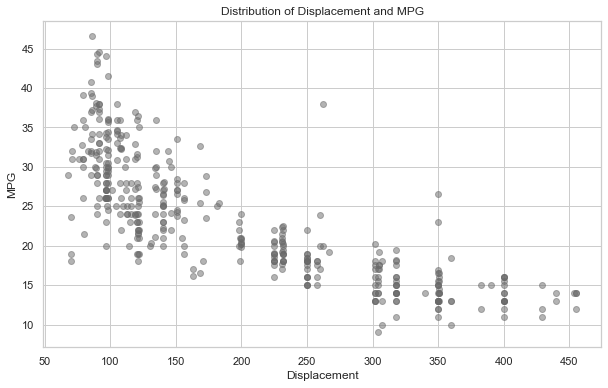

In [27]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data[ "displacement"], data["mpg"], marker="o", color="DimGray", alpha = 0.5)
axes.set_title("Distribution of Displacement and MPG")
axes.set_xlabel( "Displacement")
axes.set_ylabel( "MPG")

plt.show()
plt.close()

This is exactly what I was looking for when thinking about this data, a nice gradual decline going from the top left, to the bottom right. One thing that is sticking out to me however, is that once we get back 200 displacement, we begin to see a lot of grouping. There are a few outliers, but for the most part, we're on the right track here.

**two variable - mpg - horsepower**

data types: continuous - continuous

Expectations: Horsepower is an interesting one, as I could see this not having as negative of a coorelation as the previous two variables. However, I do believe that it will still lean that way, as a car with more horsepower will be either heavier or faster, and consume more gas as a result.

We'll look at r and rho to see how these two variables are related, to see if in fact we are dealing with a negative coorelation.

In [28]:
print( "r =", stats.pearsonr(data["horsepower"], data["mpg"])[0])
print( "rho =", stats.spearmanr(data["horsepower"], data["mpg"])[0])

r = -0.7784267838977774
rho = -0.8536164024453882


Horsepower does appear to be as negative as the previous two variable examined, so my initial assumption was a little off.

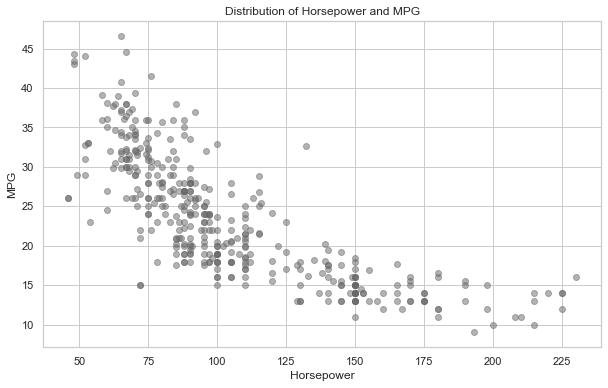

In [29]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data[ "horsepower"], data["mpg"], marker="o", color="DimGray", alpha = 0.5)
axes.set_title("Distribution of Horsepower and MPG")
axes.set_xlabel("Horsepower")
axes.set_ylabel("MPG")

plt.show()
plt.close()

Looking at the horsepower, we do see that the graph is very similar to that of displacement, however we aren't experiencing as much grouping after we get past the 125 mark. In fact we're seeing a pretty nice scatter the whole way down.

**two variable - mpg - weight**

data types: continuous - continuous

Expectations: Weight, is a continuous variable, much like the previously looked upon ones, and it matched horsepower pretty well when we looked at the single variables. My expectation is that weight does have a nice coorelation with MPG, as it takes more energy to move a heavy object than a light one.

We'll start by looking at r and rho to see how much of a coorelation we're looking at for these variables, and to see if it is negative or positve. My assumption is that this will be negatively coorelated.

In [30]:
print( "r =", stats.pearsonr(data["weight"], data["mpg"])[0])
print( "rho =", stats.spearmanr(data["weight"], data["mpg"])[0])

r = -0.8322442148315756
rho = -0.8755851198739869


It looks like weight is the strongest coorelation we've visited thus far, and it is indeed negatively coorelated, meaning the more a car weighs, the lower the MPG.

Let's graph this, to see how linear the relationship appears.

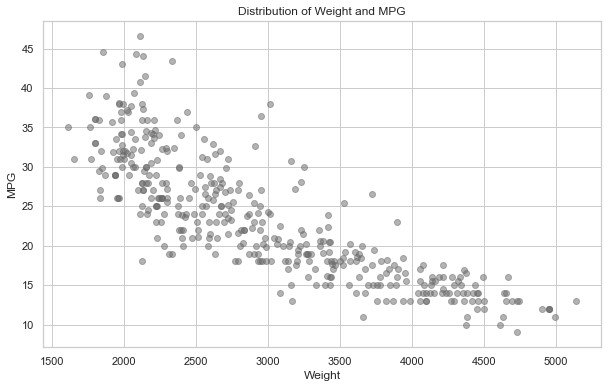

In [31]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data[ "weight"], data["mpg"], marker="o", color="DimGray", alpha = 0.5)
axes.set_title("Distribution of Weight and MPG")
axes.set_xlabel("Weight")
axes.set_ylabel("MPG")

plt.show()
plt.close()

There is a very linear relationship here. In fact, weight appears to have less of a bow in it, which is also highlighted by the higher rho value. My guess is that this will prove to be an incredibly important variable when we look to build our model.

**two variable - mpg - acceleration**

data types: continuous - continuous

Expectations: Acceleration is an interesting one, as it takes into consideration a lot of the previously examined variables including weight, horesepower, and cylinder count. My guess is that this will be more of a normally or uniformly distributed pairing, with a rho closer to zero than we've seen with the other variables.

We'll start by looking at the r and rho to see if my assumption turns out to be correct, we'll be looking closely at the rho value.

In [32]:
print( "r =", stats.pearsonr(data["acceleration"], data["mpg"])[0])
print( "rho =", stats.spearmanr(data["acceleration"], data["mpg"])[0])

r = 0.4233285369027871
rho = 0.4415388584563648


We do have a lower absolute rho value, and it's turned positive here. That's a really interesting find, as the faster cars look to be more fuel efficient than their slower counterparts. This could highlight how weight plays a role, as a heavier car will be harder to move, and will require more fuel when it does begin moving.

Next, we'll take a look at the graph, to see if it's more normally distributed than the ones we've seen in the past.

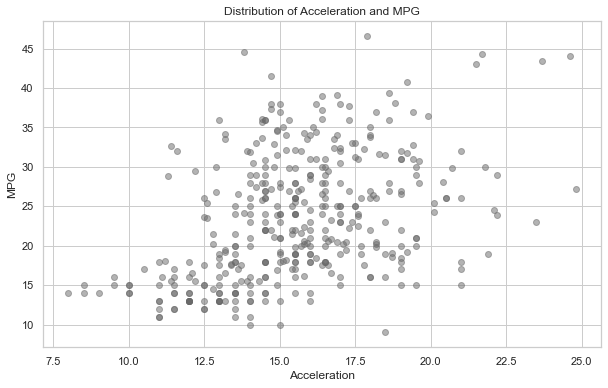

In [33]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data[ "acceleration"], data["mpg"], marker="o", color="DimGray", alpha = 0.5)
axes.set_title("Distribution of Acceleration and MPG")
axes.set_xlabel("Acceleration")
axes.set_ylabel("MPG")

plt.show()
plt.close()

This is a bit of a messy graph, but we do see that there is a slightly up slope to the points. This makes me wonder how good of an estimator acceleration is going to be when we begin to build out the model.

**two variable - mpg - Model Year**

data types: continuous - discrete

Expectations: In modern times, we expect newer vehicles to be more fuel efficienct. This wasn't always the case, as trucks and sports cars became more popular at the expense of mpg. With this, I'm interested to see how this data is going to trend, as it may differ from what we would see if looking at cars released in the 2010's. 

We'll start by looking at the rho and r values. This will help guide our expectation of whether or not the fuel efficiency is increasing by model year, or decreasing.

In [35]:
print( "r =", stats.pearsonr(data["modelyear"], data["mpg"])[0])
print( "rho =", stats.spearmanr(data["modelyear"], data["mpg"])[0])

r = 0.5805409660907846
rho = 0.5748408744472728


It looks like the 1970's has a similar trend as the 2010's with technological improvements leading to more fuel efficient cars. This coorelation isn't as strong as some other variables however, such as weight or horesepower.

I'll next look at the descriptive statistics for this pairing. At this stage, I would imagine that we'll see a gradual increase in MPG as we work our way up in years.

In [37]:
grouped = data.groupby("modelyear")
grouped_y = grouped["mpg"].describe()
print(grouped_y)

           count       mean       std   min     25%    50%     75%   max
modelyear                                                               
70          29.0  17.689655  5.339231   9.0  14.000  16.00  22.000  27.0
71          27.0  21.111111  6.675635  12.0  15.000  19.00  27.000  35.0
72          28.0  18.714286  5.435529  11.0  13.750  18.50  23.000  28.0
73          40.0  17.100000  4.700245  11.0  13.000  16.00  20.000  29.0
74          26.0  22.769231  6.537937  13.0  16.000  24.50  27.500  32.0
75          30.0  20.266667  4.940566  13.0  16.000  19.50  23.000  33.0
76          34.0  21.573529  5.889297  13.0  16.750  21.00  26.375  33.0
77          28.0  23.375000  6.675862  15.0  17.375  21.75  30.000  36.0
78          36.0  24.061111  6.898044  16.2  19.350  20.70  28.000  43.1
79          29.0  25.093103  6.794217  15.5  19.200  23.90  31.800  37.3
80          27.0  33.803704  6.885854  19.1  29.800  32.70  37.650  46.6
81          28.0  30.185714  5.635319  17.6  26.400

The descriptive statistics are showing that we are seeing a gradual increase in mpg efficiency. This can be seen in the mean, min, and maxes, all growing over time. While there isn't always an increase year to year, the trend is definitely that way.

I'll generate some box plots so that we can get a visual feel for these statistics.

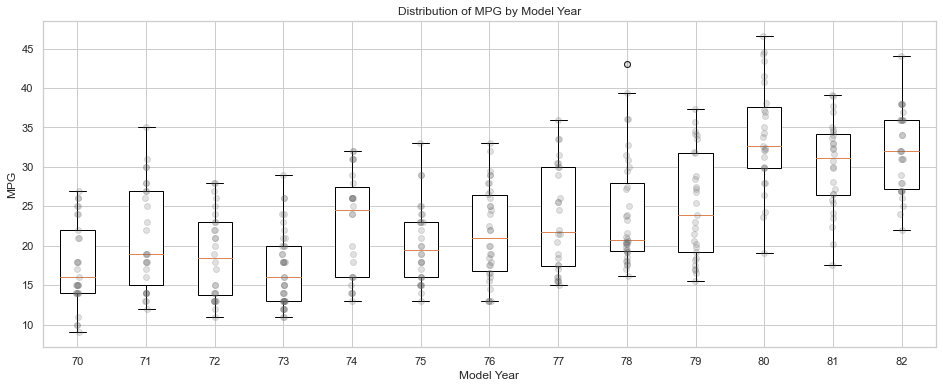

In [39]:
grouped = data.groupby("modelyear")

figure = plt.figure(figsize=(16, 6))
axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(data["modelyear"].values)
labels.sort()
grouped_data = [grouped[ "mpg"].get_group( k) for k in labels]
patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1,)

for i, k in enumerate(labels):
    subdata = grouped[ "mpg"].get_group( k)
    x = np.random.normal(i + 1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.2, color="DimGray",)
    
for b in patch['boxes']:
    b.set_facecolor('w')
    
axes.set_xlabel("Model Year")
axes.set_ylabel("MPG")
axes.set_title("Distribution of MPG by Model Year")

plt.show()
plt.close()

This definitely helps to drive home the point, we see that 82 is past 30, while 72 is below 20; this increase of over 10 mpg on average is pretty astounding. This gives support that model year may be a good variable to use when we build out our end model.

**two variable - mpg - origin**

data types: continuous - discrete

Expectations: As stated before, I'm unsure exactly what origin is, as there isn't any definition. I'll run a descriptive statistic against the variable, and put it into a box plot to help visualize, but I don't have any information to help guide my expectations.

To test the water, let's take a look at the coorelation of the two variables.

In [40]:
print( "r =", stats.pearsonr(data["origin"], data["mpg"])[0])
print( "rho =", stats.spearmanr(data["origin"], data["mpg"])[0])

r = 0.5652087567164605
rho = 0.5804824209039191


Interestingly, the origin variable looks really similar to the model year variable comparison. This means that it is positively coorelated to MPG, ableit not as strongly as some of the earlier attributes looked at.

Let's see how the descriptive statistics look, to see if our new expectation of a mpg growth with increased origin pans out.

In [41]:
grouped = data.groupby("origin")
grouped_y = grouped["mpg"].describe()
print(grouped_y)

        count       mean       std   min    25%   50%     75%   max
origin                                                             
1       245.0  20.033469  6.440384   9.0  15.00  18.5  24.000  39.0
2        68.0  27.602941  6.580182  16.2  23.75  26.0  30.125  44.3
3        79.0  30.450633  6.090048  18.0  25.70  31.6  34.050  46.6


It appears that there is a positive coorelation between the two variables, as origin increases, so does the average mpg. This is seen in the mean, min and max enteries.

I'll next take a look at the visual just to make sure I'm not missing anything too obvious.

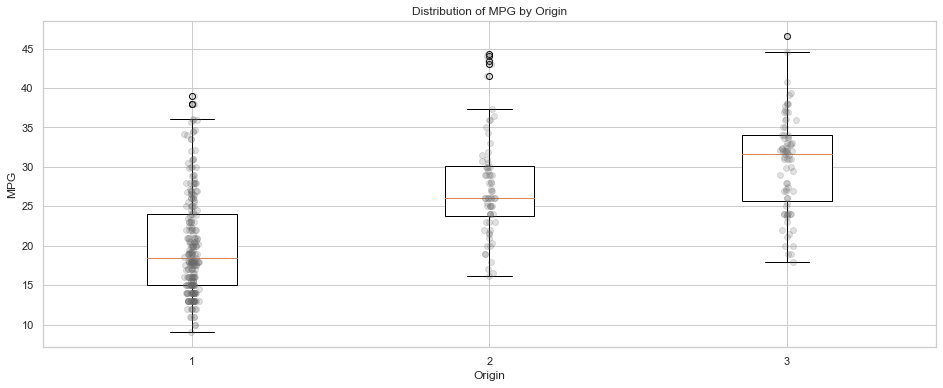

In [42]:
grouped = data.groupby("origin")

figure = plt.figure(figsize=(16, 6))
axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(data["origin"].values)
labels.sort()
grouped_data = [grouped[ "mpg"].get_group( k) for k in labels]
patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1,)

for i, k in enumerate(labels):
    subdata = grouped[ "mpg"].get_group( k)
    x = np.random.normal(i + 1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.2, color="DimGray",)
    
for b in patch['boxes']:
    b.set_facecolor('w')
    
axes.set_xlabel("Origin")
axes.set_ylabel("MPG")
axes.set_title("Distribution of MPG by Origin")

plt.show()
plt.close()

This is an interesting variable, that does look like it'll be important for our final model. It's relationship does look very similar to MPG that model year did however, so I'll need to ensure that we aren't running any mutli colinearity issues, but that'll be investigated more heavily during the model building stage.

### Take Aways:

It looks like we have some solid variables to help build a model with. Most important is that there are several that are negatively coorrelated, and several that are positively coorrelated. I don't think any of the variables are too bad, but we'll need to take a look at acceleration, because it had the lowest coorrelation of any of the attributes investigated. Additionally, there were several attributes that had a similar relationship to the target variable, MPG, so we'll need to make sure we aren't double dipping. 

## 1.3 - Build the model

Outlining the functions I'll be using for this section of the problem set.

In [58]:
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

def bootstrap_prediction(result, feature_values):
    results = []
    for coefficients in result["resampled_coefficients"].itertuples():
        estimate = 0
        for feature in feature_values.keys():
            estimate += feature_values[feature] * getattr(coefficients, feature)
            results.append(estimate)
    return np.array(results)

def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':            print("{0} P(>0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] > 0)))
        else:
            print("{0} P(<0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] < 0)))
            
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

def bootstrap_linear_regression( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = [x.strip() for x in formula.split("~")[1].split( "+")]
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in range( samples):
        sampling_indices = [ i for i in [random.randint(0, n - 1) for _ in range( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = linear_regression( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma"])
        rs.append( results[ "r_squared"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r_squared")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = linear_regression( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma"] = result[ "sigma"]
    bootstrap_results[ "r_squared"] = result[ "r_squared"]
    return bootstrap_results

def linear_regression(formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices(formula, data, return_type="matrix")
    model = linear.LinearRegression(fit_intercept=False).fit( X, y)

    result["coefficients"] = model.coef_[ 0]

    result["r_squared"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result["residuals"] = y - y_hat
    
    sum_squared_error = sum([e**2 for e in result[ "residuals"]])[0]

    n = len(result["residuals"])
    k = len(result["coefficients"])
    
    result["sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

### Baseline and Dropping Variables:

To build the model, I'm going to take a look at the variables we have at play and summarize what we know about their relationship to the target variable, MPG.

In [43]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


**Cylinders:** negative. The number of cylinders in a cars engine.

**Displacement:** negative. The measure of the cylinder volume swept by all of the pistons of a piston engine, excluding the combustion chambers.

**Horsepower:** negative. The power that the engine has, larger engines with more cylinders will generally have higher horespower.

**Weight:** negative. The weight of the car in pounds.

**Acceleration:** negative. How fast the car accelerates.

**Model Year:** positive. What year in 19YY format was the model of the vehicle.

**Origin:** positive. A sleeper variable, that appears to have a nice positive linear trend.

**Car Name:** dropped. This is a unique identifying characteristic for the line item, as a result, this isn't a variable that will assist with the modeling process.

One note, is that I've dropped Car Name, as it's a unique identifier for the rows, but doesn't do anything for the modeling portion.

I'll be running a bootstrapped linear regression with all of the variables, to see if they match our expectations above. We'll primarilly be looking to see if there are any variables that look like may warrent a drop.

In [188]:
model = "mpg ~ cylinders + displacement + horsepower + weight + acceleration + modelyear + origin"
result = bootstrap_linear_regression(model, data=data)
print(models.describe_bootstrap_lr(result))

Model: mpg ~ cylinders + displacement + horsepower + weight + acceleration + modelyear + origin
------------  ---------  ------  -------  -----
                                 95% BCI
Coefficients             Mean    Lo       Hi
              $\beta_0$  -17.22  -23.14   -6.92
cylinders     $\beta_1$  -0.49   -1.14    0.14
displacement  $\beta_2$  0.02    0.00     0.04
horsepower    $\beta_3$  -0.02   -0.05    0.00
weight        $\beta_4$  -0.01   -0.01    -0.00
acceleration  $\beta_5$  0.08    -0.19    0.28
modelyear     $\beta_6$  0.75    0.64     0.82
origin        $\beta_7$  1.43    0.91     1.92

Metrics       Mean       Lo      Hi
$\sigma$      3.33       2.97    3.57
$R^2$         0.82       0.80    0.85
------------  ---------  ------  -------  -----


Looking at our baseline, we have 0.82 for an R^2, which is pretty good actually. Also of note, is the ranges of the variables, primarilly if zero is in the range.

We'll be using this information, coupled with the probability of the sign to show if the variable is appropriate to include.

In [189]:
predictions = {
"cylinders": '-',
"displacement": '-',
"horsepower": '-',
"weight": '-',
"acceleration": '-',
"modelyear": '+',
"origin": '+'}

evaluate_coefficient_predictions(predictions, result)

cylinders P(<0)=0.920
displacement P(<0)=0.010
horsepower P(<0)=0.950
weight P(<0)=1.000
acceleration P(<0)=0.400
modelyear P(>0)=1.000
origin P(>0)=1.000


Taking a look at the cooefficients, we see that acceleration and displacement don't have the signs that we expect, and include zero. As a result of this, and since we've already seen some strange trends with the two variables, grouping for displacement and scattering for acceleration, I'll be dropping those two variables from the model.

In [190]:
model = "mpg ~ cylinders + horsepower + weight + modelyear + origin"
result = bootstrap_linear_regression(model, data=data)
print(models.describe_bootstrap_lr(result))

Model: mpg ~ cylinders + horsepower + weight + modelyear + origin
------------  ---------  ------  -------  -----
                                 95% BCI
Coefficients             Mean    Lo       Hi
              $\beta_0$  -16.96  -23.13   -9.90
cylinders     $\beta_1$  0.05    -0.37    0.43
horsepower    $\beta_2$  -0.01   -0.03    0.01
weight        $\beta_3$  -0.01   -0.01    -0.00
modelyear     $\beta_4$  0.74    0.65     0.82
origin        $\beta_5$  1.20    0.65     1.69

Metrics       Mean       Lo      Hi
$\sigma$      3.35       2.94    3.57
$R^2$         0.82       0.80    0.85
------------  ---------  ------  -------  -----


In [191]:
models.adjusted_r_squared(result)

0.8147641121792685

Our R^2 is still 82, so we don't see any movement in how good the model fits the data, but our sigma has tightened up a bit, so we're getting less variation in the model which is good.

We'll start looking at the five remaining variables to see if we can perform any transformations to improve the fit of our model.

### Looking at Residuals:

We're now left with five variables [Cylinders, Horsepower, Weight, Model Year, Origin]. Of these variables, we'll take a look at the residuals to see if a transformation would be warrented.

I'll start by looking at all of the residuals, to see if we notice any clumping, or clear trends, such as sloping, or breaks in the linear models.

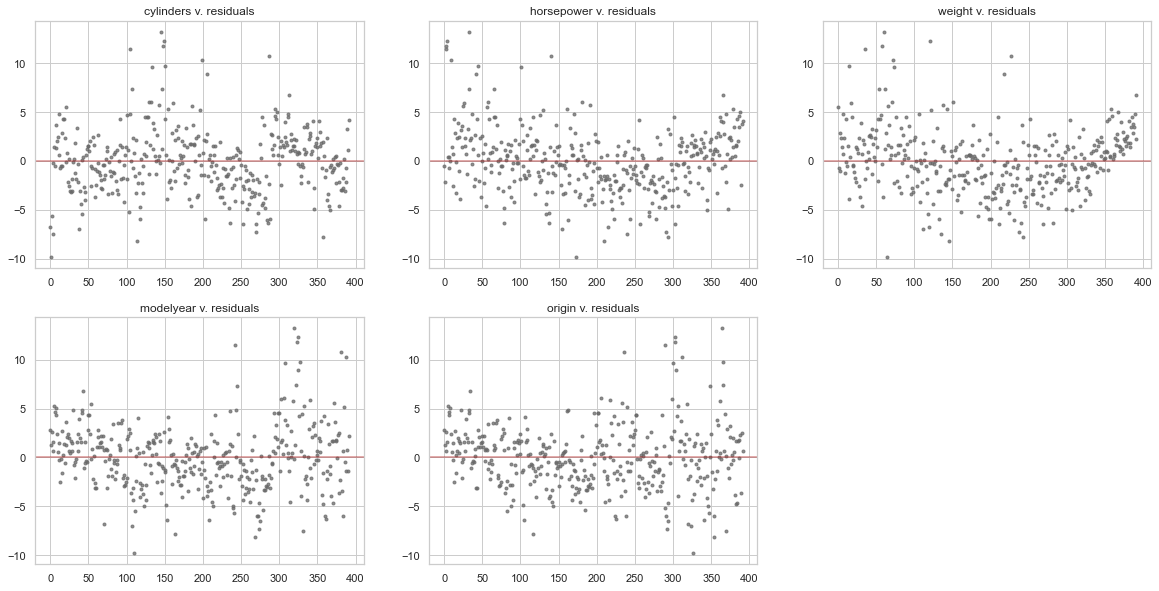

In [192]:
figure = plt.figure(figsize=(20,10))
variables = ["cylinders", "horsepower", "weight", "modelyear", "origin"]
plots = len( variables)
rows = (plots // 3) + 1
for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( data[ variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")
plt.show()
plt.close()


We've running into a few issues. For cylinders, there's a break in the data, for horsepower and weight there is clumping near the end, and there is scattering occuring for model year and origin. I'll be performing the following transformations to try and address each of the issues.

**transformations**

MPG - log

Cylinders - Square Root

Horsepower - Log

Weight - Log

Model Year - Square Root 

Origin - Squared

In [224]:
data["cylinders_root"] = data["cylinders"]**(1/2)
data["horsepower_log"] = np.log(data["horsepower"])
data["weight_log"] = np.log(data["weight"])
data["modelyear_squared"] = data["modelyear"]**(1/2)
data["origin_squared"] = data["origin"]**2
data["mpg_log"] = np.log(data["mpg"])

Let's examine that residuals of our new variables, to see if we've helped to address the issues we had previously been experiencing. I'd expect that we'll still see a phantom of the issue, but that it'll be much less pronounced.

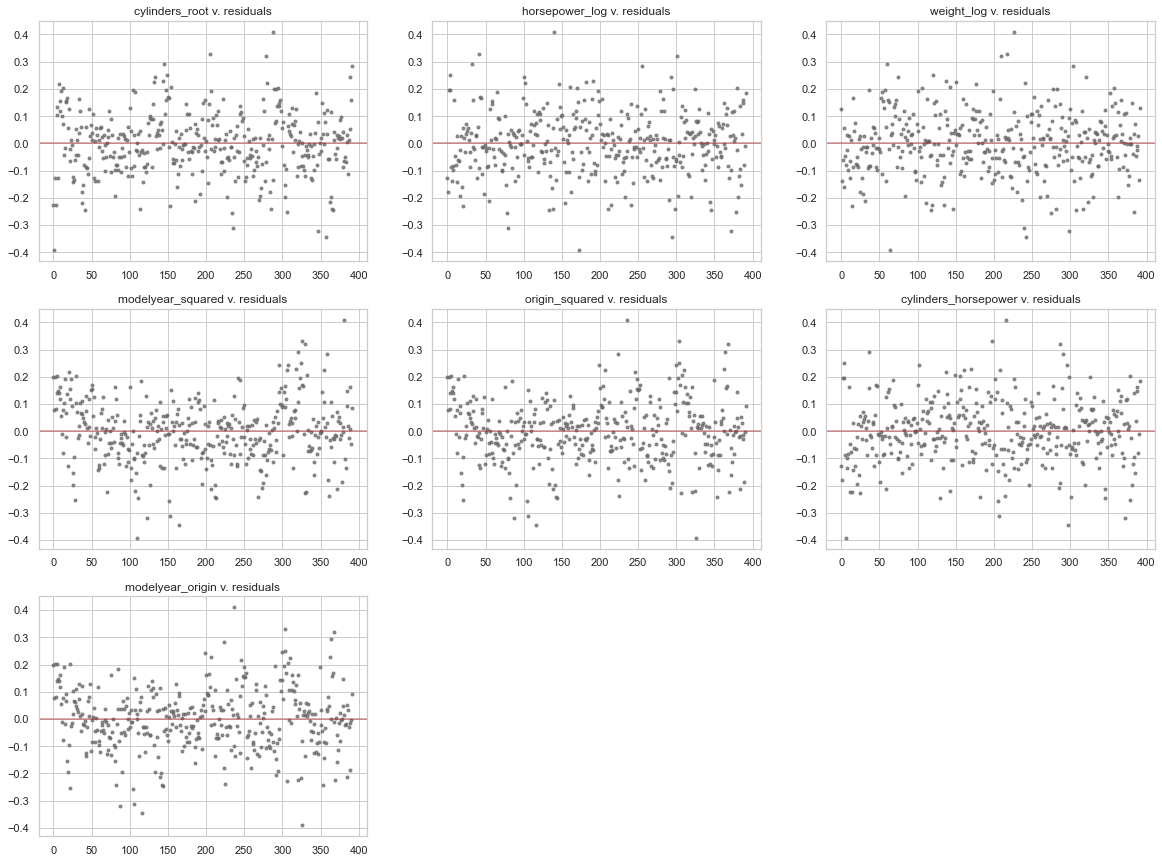

In [225]:
figure = plt.figure(figsize=(20,15))
variables = ["cylinders_root", "horsepower_log", "weight_log", "modelyear_squared", "origin_squared", "cylinders_horsepower", "modelyear_origin"]
plots = len( variables)
rows = (plots // 3) + 1
for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( data[variable].values, result[ "residuals"]),key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")
plt.show()
plt.close()

Things are looking a lot better after the transformations. Let's take a look at our model's fit to see if we've gotten any movement there. My expectation is that we've seen some nice improvements.

We'll examine our model at this point, to see if we have adjusted the error or the fit of the model. My expectation is that we will be working with a smaller error, while improving our fit.

In [232]:
model = "mpg_log ~ cylinders_root + horsepower_log + weight_log + modelyear_squared + origin_squared"
result = bootstrap_linear_regression(model, data=data)
print(models.describe_bootstrap_lr(result))

Model: mpg_log ~ cylinders_root + horsepower_log + weight_log + modelyear_squared + origin_squared
-----------------  ---------  -----  -------  -----
                                     95% BCI
Coefficients                  Mean   Lo       Hi
                   $\beta_0$  4.88   4.15     5.68
cylinders_root     $\beta_1$  -0.05  -0.16    0.02
horsepower_log     $\beta_2$  -0.16  -0.23    -0.05
weight_log         $\beta_3$  -0.69  -0.81    -0.58
modelyear_squared  $\beta_4$  0.52   0.45     0.58
origin_squared     $\beta_5$  0.00   0.00     0.01

Metrics            Mean       Lo     Hi
$\sigma$           0.11       0.11   0.13
$R^2$              0.89       0.87   0.91
-----------------  ---------  -----  -------  -----


From here, it looks like origin_squared is actually a non factor as the cooefficient is actually zero. As a result, I'll remove it and rerun this to see what that does to our R^2. My expectation is that it will have no effect.

In [233]:
model = "mpg_log ~ cylinders_root + horsepower_log + weight_log + modelyear_squared"
result = bootstrap_linear_regression(model, data=data)
print(models.describe_bootstrap_lr(result))

Model: mpg_log ~ cylinders_root + horsepower_log + weight_log + modelyear_squared
-----------------  ---------  -----  -------  -----
                                     95% BCI
Coefficients                  Mean   Lo       Hi
                   $\beta_0$  5.10   4.44     5.77
cylinders_root     $\beta_1$  -0.06  -0.15    0.02
horsepower_log     $\beta_2$  -0.14  -0.22    -0.05
weight_log         $\beta_3$  -0.72  -0.85    -0.60
modelyear_squared  $\beta_4$  0.52   0.45     0.59

Metrics            Mean       Lo     Hi
$\sigma$           0.12       0.11   0.12
$R^2$              0.89       0.86   0.91
-----------------  ---------  -----  -------  -----


We see some slight movement in the sigma and our beta_0, but not enough to warrent keeping the origin in the model. We'll keep it out going forward.

In [234]:
models.adjusted_r_squared(result)

0.8845834084343251

We some some nice movement of our R^2. We'll be working with this model as our final for the prediction portion of the assignment.

## 1.4 - Describe the model

### Model Overview:

Looking at the finalized midel, I'll be outlining each of the different variables that we're addressing, and then calculating the cooefficients. From there, I'll outline the exact model that we'll be using to predict.

**Variables:**

mpg_log - Target Variable, taken MPG and calculated the natural log.

cylinders_root - The square root of the number of cylinders present.

horsepower_log - The natural log of the vehicles horsepower

weight_log - The natural log of the vehicles weight.

modelyear_squared - The square root of the vehciles model year.

Instead of using a Bootstrap Linear Regression, in order to get the exact cooefficients that we'll be utilizing the linear_regression function, so that we can identify the cooefficients to utilize.

In [235]:
model = "mpg_log ~ cylinders_root + horsepower_log + weight_log + modelyear_squared"
result = linear_regression(model, data=data)
print(models.simple_describe_lr(result))

Model: mpg_log ~ cylinders_root + horsepower_log + weight_log + modelyear_squared
-----------------  ---------  -----
Coefficients                  Value
                   $\beta_0$  5.10
cylinders_root     $\beta_1$  -0.06
horsepower_log     $\beta_2$  -0.14
weight_log         $\beta_3$  -0.72
modelyear_squared  $\beta_4$  0.52

Metrics            Value
$\sigma$           0.12
$R^2$              0.89
-----------------  ---------  -----


Our final model will be:

mpg_log = 5.10 + cylinders_root*(-0.06) + horsepower_log*(-0.14) + weight_log*(-0.72) +  modelyear_squared*(0.52)

From here we can perform our prediction to see how our model performs.

## 1.5 - Use the model

To jump right in, we'll be performing our prediction on the entire dataset, and then see how far off our model is.

In [236]:
data["predict"] = 5.10 + data["cylinders_root"]*(-0.06) + data["horsepower_log"]*(-0.14) + data["weight_log"]*(-0.72) + data["modelyear_squared"]*(0.52)

Now in order to compare apples to apples, I'll calculate the exponential of this number, as our prediction is currently in natural log form.

In [239]:
data["predict_final"] = np.exp(data["predict"])

To see how well our model predicted compared to the real mpg, I'll take the difference and then plot the values.

In [240]:
data["difference"] = data["mpg"] - data["predict_final"]

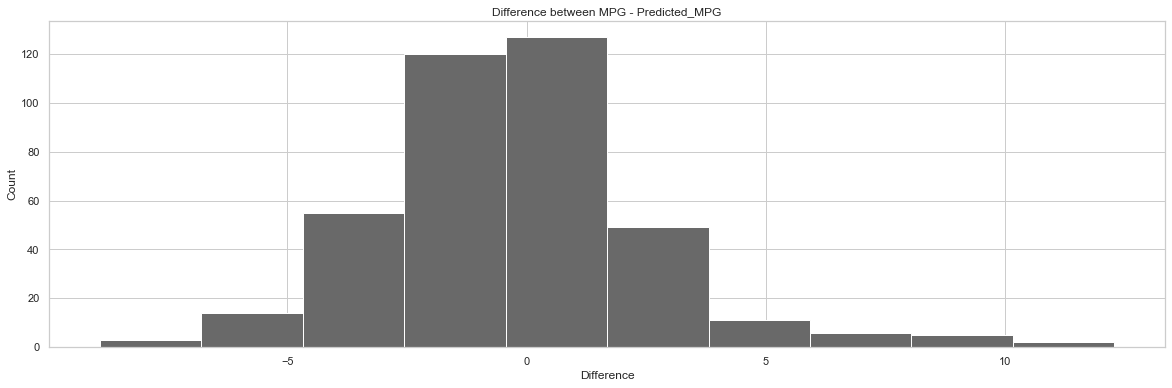

In [243]:
sns.set(style="whitegrid")

figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)

axes.hist(data["difference"],  color="dimgray")
axes.set_title( "Difference between MPG - Predicted_MPG")
axes.set_xlabel("Difference")
axes.set_ylabel("Count")

plt.show()
plt.close()

We have a pretty normal distribution, that is hovering just around 0, which is exactly what we want. We do have a longer tail on the right, but the bulk of our data is where we want it to be.

I'll take a look at how the values are defined by using the describe function.

In [244]:
data["difference"].describe()

count    392.000000
mean      -0.316177
std        2.860576
min       -8.924185
25%       -1.876666
50%       -0.390145
75%        0.940223
max       12.290988
Name: difference, dtype: float64

The mean value is -0.316, which is pretty good, and our standard deviation is 2.86. I'm pretty happy with how this model came out in the end. We've done a nice job getting close to the original values, and we learned a lot along the way.



---

**CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.



*   Have you completed every section and answered every question asked?
*   For every question, have you described your approach and explained your results?
*   Have you checked for spelling and grammar errors?
*   Are your code blocks free of any errors?
*   Have you *SAVED* your notebook?

